# Visual Question Answering using Multimodal Transformer Models

## Import necessary libraries & set up the environment

In [1]:
## Import necessary libraries
import os
import json
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled, Dataset, DatasetDict
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import random
import re
from collections import defaultdict


VQAV2_FILEPATH = "./VQAv2 Annotations Preprocessed"
OUTPUT_DIR = "Checkpoint_VQA_3129_Dropped_NaN"

MODEL_NAME = 'cnn_lstm_baseline_batch32'
TEXT_MODEL = None
# 'google/vit-base-patch16-224-in21k'
IMAGE_MODEL = None
REDUCED_YES_NO = False
SAMPLES = 12468
SAMPLE_BOOL = False
RANDOM_STATE = 12345


2023-04-14 17:45:22.924654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

2023-04-14 17:45:23.872286: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

2023-04-14 17:45:25.508341: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory

2023-04-14 17:45:25.508420: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; 

In [2]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# os.environ["WANDB_DISABLED"] = "false"

set_caching_enabled(True)
logging.set_verbosity_error()

/tmp/ipykernel_8458/2343905411.py:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.

  set_caching_enabled(True)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0

NVIDIA GeForce RTX 3090


In [5]:
## Open the training set of the VQA v2.0 dataset

df_combined = pd.read_csv(os.path.join(
    VQAV2_FILEPATH, "VQAv2_train_preprocessed.csv"))
df_combined

,question,answer,answer_type,image_id,label
0,What is this photo taken looking through?,net,other,train2014/train2014/COCO_train2014_00000045875...,1036
1,What position is this man playing?,pitcher,other,train2014/train2014/COCO_train2014_00000045875...,2092
2,What color is the players shirt?,orange,other,train2014/train2014/COCO_train2014_00000045875...,2693
3,Is this man a professional baseball player?,yes,yes/no,train2014/train2014/COCO_train2014_00000045875...,2259
4,What color is the snow?,white,other,train2014/train2014/COCO_train2014_00000026214...,2580
...,...,...,...,...,...
413428,How many keyboards are there?,2,number,train2014/train2014/COCO_train2014_00000052428...,2013
413429,What color is the keyboard?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486
413430,Is there a computer mouse on the desk?,no,yes/no,train2014/train2014/COCO_train2014_00000052428...,2194
413431,What color is the computer?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486


In [6]:
## (Optional) Remove some yes/no questions to address overrepresentation of this question type

yes_no_questions = df_combined.index[df_combined['answer_type']
                                     == 'yes/no'].tolist()
print(len(yes_no_questions))
random.shuffle(yes_no_questions)

df_combined_dropped = df_combined
if REDUCED_YES_NO:
    df_combined_dropped = df_combined.drop(yes_no_questions[:120000])

# df_combined_dropped.reset_index()
df_combined_dropped


166881


,question,answer,answer_type,image_id,label
0,What is this photo taken looking through?,net,other,train2014/train2014/COCO_train2014_00000045875...,1036
1,What position is this man playing?,pitcher,other,train2014/train2014/COCO_train2014_00000045875...,2092
2,What color is the players shirt?,orange,other,train2014/train2014/COCO_train2014_00000045875...,2693
3,Is this man a professional baseball player?,yes,yes/no,train2014/train2014/COCO_train2014_00000045875...,2259
4,What color is the snow?,white,other,train2014/train2014/COCO_train2014_00000026214...,2580
...,...,...,...,...,...
413428,How many keyboards are there?,2,number,train2014/train2014/COCO_train2014_00000052428...,2013
413429,What color is the keyboard?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486
413430,Is there a computer mouse on the desk?,no,yes/no,train2014/train2014/COCO_train2014_00000052428...,2194
413431,What color is the computer?,black,other,train2014/train2014/COCO_train2014_00000052428...,2486


In [7]:
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')

def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens


df_combined_dropped["question_tokens"] = df_combined_dropped["question"].apply(lambda x:tokenize(x))

In [8]:
## Load the answer to label mappings for the VQA v2.0 dataset (total of 3,129 answers)
with open(f"{VQAV2_FILEPATH}/VQAv2_answer_mapping.json", "r") as json_file:
    answer_to_id = json.load(json_file)

answer_space = list(answer_to_id.keys())
print(len(answer_to_id))
answer_to_id

{'bathroom': 0,
 'wetsuits': 1,
 'fish': 2,
 'dachshund': 3,
 'child': 4,
 'british airways': 5,
 'first base': 6,
 'american': 7,
 'red sox': 8,
 'salmon': 9,
 'wine glasses': 10,
 'above': 11,
 'baseball game': 12,
 '3:10': 13,
 'octopus': 14,
 'goose': 15,
 'alive': 16,
 'luggage': 17,
 'very fast': 18,
 'wood': 19,
 'goal': 20,
 'wool': 21,
 'sushi': 22,
 'umbrella': 23,
 'out': 24,
 'driveway': 25,
 'nobody': 26,
 'handle': 27,
 'marble': 28,
 'mouse': 29,
 'spider': 30,
 'down street': 31,
 'roll': 32,
 '11:55': 33,
 'egg salad': 34,
 '7:05': 35,
 'german': 36,
 'focus': 37,
 'red and blue': 38,
 'kickstand': 39,
 'setting': 40,
 'chocolate': 41,
 '39': 42,
 '101': 43,
 'on sign': 44,
 'years': 45,
 'beige': 46,
 'parking': 47,
 'cat food': 48,
 'cute': 49,
 'crates': 50,
 'tomato': 51,
 'laughing': 52,
 'sand': 53,
 'pans': 54,
 'yellow and white': 55,
 'foreground': 56,
 'african': 57,
 '6:20': 58,
 'conductor': 59,
 '3:30': 60,
 'bnsf': 61,
 'in basket': 62,
 'purple and white

In [9]:
id_to_answer = {v: k for k, v in answer_to_id.items()}

{0: 'bathroom',
 1: 'wetsuits',
 2: 'fish',
 3: 'dachshund',
 4: 'child',
 5: 'british airways',
 6: 'first base',
 7: 'american',
 8: 'red sox',
 9: 'salmon',
 10: 'wine glasses',
 11: 'above',
 12: 'baseball game',
 13: '3:10',
 14: 'octopus',
 15: 'goose',
 16: 'alive',
 17: 'luggage',
 18: 'very fast',
 19: 'wood',
 20: 'goal',
 21: 'wool',
 22: 'sushi',
 23: 'umbrella',
 24: 'out',
 25: 'driveway',
 26: 'nobody',
 27: 'handle',
 28: 'marble',
 29: 'mouse',
 30: 'spider',
 31: 'down street',
 32: 'roll',
 33: '11:55',
 34: 'egg salad',
 35: '7:05',
 36: 'german',
 37: 'focus',
 38: 'red and blue',
 39: 'kickstand',
 40: 'setting',
 41: 'chocolate',
 42: '39',
 43: '101',
 44: 'on sign',
 45: 'years',
 46: 'beige',
 47: 'parking',
 48: 'cat food',
 49: 'cute',
 50: 'crates',
 51: 'tomato',
 52: 'laughing',
 53: 'sand',
 54: 'pans',
 55: 'yellow and white',
 56: 'foreground',
 57: 'african',
 58: '6:20',
 59: 'conductor',
 60: '3:30',
 61: 'bnsf',
 62: 'in basket',
 63: 'purple and w

In [10]:
## Split the provided training set into our own training and test sets for use in training and evaluating our models.
## Use stratified sampling to maintain the same distribution of question types in the train and test splits.

train_df, test_df = train_test_split(df_combined_dropped, test_size=0.2, random_state=RANDOM_STATE,
                                     shuffle=True, stratify=df_combined_dropped['answer_type'])

train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
dataset


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label', 'question_tokens'],
        num_rows: 330746
    })
    test: Dataset({
        features: ['question', 'answer', 'answer_type', 'image_id', 'label', 'question_tokens'],
        num_rows: 82687
    })
})

In [11]:
## Verify that the distributions of question types in the train and test splits are the same.
print("Training set:")
print(train_df['answer_type'].value_counts(normalize=True) * 100)
print(train_df['answer_type'].value_counts())
print("\nTest set:")
print(test_df['answer_type'].value_counts(normalize=True) * 100)
print(test_df['answer_type'].value_counts())

other     46.458007

yes/no    40.364812

number    13.177181

Name: answer_type, dtype: float64

other     153658

yes/no    133505

number     43583

Name: answer_type, dtype: int64



other     46.458331

yes/no    40.364265

number    13.177404

Name: answer_type, dtype: float64

other     38415

yes/no    33376

number    10896

Name: answer_type, dtype: int64


In [13]:
## To show a sample with its image and question, along with the answer and its corresponding id

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join(VQAV2_FILEPATH, data[id]['image_id']))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"],
          "(Label: {0})".format(data[id]["label"]))


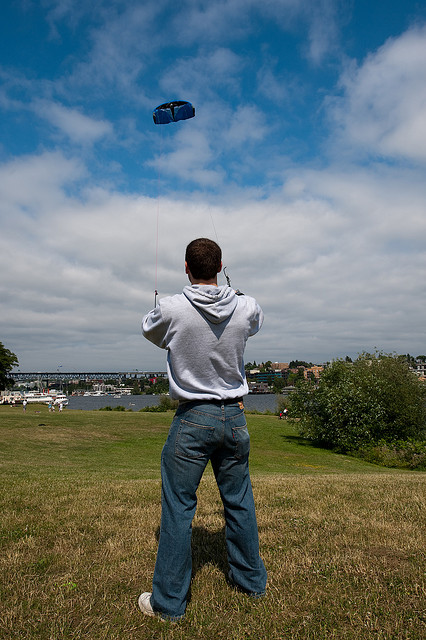

Question:	 What is the man doing?

Answer:		 flying kite (Label: 113)


In [14]:
showExample()

In [15]:
def make_vocab_questions():
    """Make dictionary for questions and save them into text file."""

    vocab_set = set()
    SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')
    question_length = []
    #     for dataset in datasets:
    #         with open(input_dir+'/'+dataset) as f:
    #             questions = json.load(f)['questions']
    #         set_question_length = [None]*len(questions)
    uniqueQuestions = df_combined_dropped["question"].unique()
    set_question_length = [None]*len(uniqueQuestions)
    for iquestion, question in enumerate(uniqueQuestions):
        words = SENTENCE_SPLIT_REGEX.split(question.lower())
        words = [w.strip() for w in words if len(w.strip()) > 0]
        vocab_set.update(words)
        set_question_length[iquestion] = len(words)
    question_length += set_question_length

    question_vocab_list = list(vocab_set)
    question_vocab_list.sort()
    question_vocab_list.insert(0, '<pad>')
    question_vocab_list.insert(1, '<unk>')
    print('The number of total words of questions: %d' % len(vocab_set))
    print('Maximum length of question: %d' % np.max(question_length))
    return question_vocab_list


question_vocab_list = make_vocab_questions()
question_vocab_list


The number of total words of questions: 12688

Maximum length of question: 24


['<pad>',
 '<unk>',
 '!"?',
 '!."?',
 '"',
 '" -',
 '"\'',
 '")',
 '"+"',
 '"?',
 '#',
 '#?',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'?",
 "'^'",
 '(',
 '("',
 ')',
 ')?',
 '*',
 ',',
 ', "',
 ", '",
 ", '...",
 '-',
 '.',
 '."?',
 ".'?",
 '.,',
 '..',
 '...',
 '...?',
 '.?',
 '/',
 '0',
 '00',
 '000',
 '01',
 '02',
 '03',
 '06',
 '1',
 '10',
 '100',
 '100k',
 '100m',
 '106',
 '11',
 '11th',
 '12',
 '12th',
 '13',
 '130th',
 '14',
 '144',
 '14th',
 '15',
 '150',
 '1560',
 '16',
 '17',
 '172',
 '17th',
 '18',
 '1800s',
 '189',
 '1899',
 '19',
 '1900',
 '1920s',
 '1930',
 '1940',
 '1950',
 '1960',
 '1970',
 '1970s',
 '1974',
 '1980',
 '1980s',
 '1989',
 '1990',
 '1993',
 '1999',
 '19th',
 '1st',
 '2',
 '20',
 '200',
 '2000',
 '2010',
 '2012',
 '2014',
 '2015',
 '2016',
 '2017',
 '2029',
 '20th',
 '21',
 '21st',
 '22',
 '222',
 '23',
 '24',
 '243',
 '25',
 '250',
 '256',
 '25th',
 '26',
 '27',
 '2700',
 '28',
 '29',
 '29013',
 '2ft',
 '2nd',
 '2pm',
 '3',
 '30',
 '300',
 '3000',
 '32',
 '336',


In [16]:
def make_vocab_answers():
    """Make dictionary for top n answers and save them into text file."""
    answers = defaultdict(lambda: 0)
#     datasets = os.listdir(input_dir)
    for answer in df_combined_dropped["answer"]:
        word = answer
#         if word == None:
#             continue
        try:
            if re.search(r"[^\w\s]", word):
                continue
        except:
            print(word)
        answers[word] += 1

    answers = sorted(answers, key=answers.get, reverse=True)
    assert ('<unk>' not in answers)
#     top_answers = ['<unk>'] + answers[:n_answers-1] # '-1' is due to '<unk>'

#     with open('../datasets/vocab_answers.txt', 'w') as f:
#         f.writelines([w+'\n' for w in top_answers])
    return answers
    print('Make vocabulary for answers')
    print('The number of total words of answers: %d' % len(answers))


#     print('Keep top %d answers into vocab' % n_answers)
answers_vocab_list = make_vocab_answers()


In [17]:
SENTENCE_SPLIT_REGEX = re.compile(r'(\W+)')


def tokenize(sentence):
    tokens = SENTENCE_SPLIT_REGEX.split(sentence.lower())
    tokens = [t.strip() for t in tokens if len(t.strip()) > 0]
    return tokens


# def load_str_list(fname):
#     with open(fname) as f:
#         lines = f.readlines()
#     lines = [l.strip() for l in lines]
#     return lines


class VocabDict:

    def __init__(self, word_list):
        self.word_list = word_list
        self.word2idx_dict = {w: n_w for n_w, w in enumerate(self.word_list)}
        self.vocab_size = len(self.word_list)
        self.unk2idx = self.word2idx_dict['<unk>'] if '<unk>' in self.word2idx_dict else None

    def idx2word(self, n_w):

        return self.word_list[n_w]

    def word2idx(self, w):
        if w in self.word2idx_dict:
            return self.word2idx_dict[w]
        elif self.unk2idx is not None:
            return self.unk2idx
        else:
            raise ValueError(
                'word %s not in dictionary (while dictionary does not contain <unk>)' % w)

    def tokenize_and_index(self, sentence):
        inds = [self.word2idx(w) for w in tokenize(sentence)]

        return inds


In [18]:
qst_vocab = VocabDict(question_vocab_list)
ans_vocab = VocabDict(answers_vocab_list)


idx = 3
load_ans = True
vqa = dataset['train']


def process_qst_vocab(question):
    # padded with '<pad>' in 'ans_vocab'
    qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
    qst2idc[:len(question['question_tokens'])] = [qst_vocab.word2idx(w)
                                                  for w in question['question_tokens']]


def ans2idc(ans):
    ans2idc = [ans_vocab.word2idx(ans)]
    ans2idx = np.random.choice(ans2idc)
    return ans2idx
    # sample['answer_label'] = ans2idx


max_qst_length = 30
image_id = vqa[idx]['image_id']
image = Image.open(os.path.join(VQAV2_FILEPATH, image_id)).convert('RGB')
# padded with '<pad>' in 'ans_vocab'
qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
qst2idc[:len(vqa[idx]['question_tokens'])] = [qst_vocab.word2idx(w)
                                              for w in vqa[idx]['question_tokens']]
sample = {'image': image, 'question': qst2idc}

if load_ans:
    #     ans2idc = [ans_vocab.word2idx(vqa[idx]['answer'])]
    #     ans2idx = np.random.choice(ans2idc)
    sample['answer_label'] = ans2idc(vqa[idx]['answer'])      # for training

#     mul2idc = list([-1] * max_num_ans)       # padded with -1 (no meaning) not used in 'ans_vocab'
#     mul2idc[:len(ans2idc)] = ans2idc         # our model should not predict -1
#     sample['answer_multi_choice'] = ans2idc  # for evaluation metric of 'multiple choice'

# if transform:
#     sample['image'] = transform(sample['image'])

# return sample
print(vqa[idx]["label"])
sample


947


{'image': <PIL.Image.Image image mode=RGB size=640x539>,
 'question': array([12383,  4666,  5912,  7611, 11368,  3219,   191,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]),
 'answer_label': 528}

In [19]:
@dataclass
class MultimodalCollator:
    def ans2idc(self, ans):
        ans2idc = [ans_vocab.word2idx(ans)]
        ans2idx = np.random.choice(ans2idc)
        return ans2idx
        sample['answer_label'] = ans2idx

    def process_qst_vocab(self, question_tokens):
        qst2idcList = []
#         print(question_tokens)
        for i, v in enumerate(question_tokens):
            # padded with '<pad>' in 'ans_vocab'
            qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)
            qst2idc[:len(v)] = [qst_vocab.word2idx(w) for w in v]
            qst2idcList.append(qst2idc)

        # Convert the list of numpy arrays to a single numpy array
        qst_np_array = np.array(qst2idcList)
        # Convert the numpy array to a long tensor
        qst_tensor = torch.tensor(qst_np_array, dtype=torch.long)
        return {"qst": qst_tensor}

    def preprocess_images(self, images: List[str], target_width: int = 384, target_height: int = 384):
        #         imgList = [np.array(Image.open(os.path.join(VQAV2_FILEPATH, image_id)).convert('RGB')) for image_id in images]
        #         return {"img": torch.tensor(imgList)}
        imgList = []
        for image_id in images:
            img = Image.open(os.path.join(
                VQAV2_FILEPATH, image_id)).convert('RGB')
            img_resized = img.resize((target_width, target_height))
            imgList.append(np.array(img_resized))
        imgArray = np.stack(imgList, axis=0)
        # Change the shape to Batch_size x Channels x Height x Width
        imgArray = np.transpose(imgArray, (0, 3, 1, 2))
        # Convert the array to a float32 tensor
        return {"img": torch.tensor(imgArray, dtype=torch.float32)}

    def __call__(self, raw_batch_dict):
        return {
            **self.process_qst_vocab(
                raw_batch_dict['question_tokens']
                if isinstance(raw_batch_dict, dict) else
                [i['question_tokens'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            #             'labels': torch.tensor(
            #                 self.ans2idc(raw_batch_dict['question']),
            #                 dtype=torch.int64
            #             ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }


In [20]:
print(qst_vocab.vocab_size)
print(ans_vocab.vocab_size)


12690

2980


In [21]:
class ImgEncoder(nn.Module):

    def __init__(self, embed_size):
        """(1) Load the pretrained model as you want.
               cf) one needs to check structure of model using 'print(model)'
                   to remove last fc layer from the model.
           (2) Replace final fc layer (score values from the ImageNet)
               with new fc layer (image feature).
           (3) Normalize feature vector.
        """
        super(ImgEncoder, self).__init__()
        model = models.vgg19(pretrained=True)
        # input size of feature vector
        in_features = model.classifier[-1].in_features
        model.classifier = nn.Sequential(
            *list(model.classifier.children())[:-1])    # remove last fc layer

        # loaded model without last fc layer
        self.model = model
        # feature vector of image
        self.fc = nn.Linear(in_features, embed_size)

    def forward(self, image):
        """Extract feature vector from image vector.
        """
        with torch.no_grad():
            # [batch_size, vgg16(19)_fc=4096]
            img_feature = self.model(image)
        # [batch_size, embed_size]
        img_feature = self.fc(img_feature)

        l2_norm = img_feature.norm(p=2, dim=1, keepdim=True).detach()
        # l2-normalized feature vector
        img_feature = img_feature.div(l2_norm)

        return img_feature


class QstEncoder(nn.Module):

    def __init__(self, qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size):

        super(QstEncoder, self).__init__()
        self.word2vec = nn.Embedding(qst_vocab_size, word_embed_size)
        self.tanh = nn.Tanh()
        self.lstm = nn.LSTM(word_embed_size, hidden_size, num_layers)
        # 2 for hidden and cell states
        self.fc = nn.Linear(2*num_layers*hidden_size, embed_size)

    def forward(self, question):

        # [batch_size, max_qst_length=30, word_embed_size=300]
        qst_vec = self.word2vec(question)
        qst_vec = self.tanh(qst_vec)
        # [max_qst_length=30, batch_size, word_embed_size=300]
        qst_vec = qst_vec.transpose(0, 1)
        # [num_layers=2, batch_size, hidden_size=512]
        _, (hidden, cell) = self.lstm(qst_vec)
        # [num_layers=2, batch_size, 2*hidden_size=1024]
        qst_feature = torch.cat((hidden, cell), 2)
        # [batch_size, num_layers=2, 2*hidden_size=1024]
        qst_feature = qst_feature.transpose(0, 1)
        # [batch_size, 2*num_layers*hidden_size=2048]
        qst_feature = qst_feature.reshape(qst_feature.size()[0], -1)
        qst_feature = self.tanh(qst_feature)
        # [batch_size, embed_size]
        qst_feature = self.fc(qst_feature)

        return qst_feature


class BaselineVQAModel(nn.Module):
    def __init__(self, embed_size=1024,
                 qst_vocab_size=qst_vocab.vocab_size,
                 ans_vocab_size=len(answer_space),  # ans_vocab.vocab_size,
                 word_embed_size=300,
                 num_layers=2, hidden_size=512,
                 num_labels: int = len(answer_space)):

        super(BaselineVQAModel, self).__init__()
        self.img_encoder = ImgEncoder(embed_size)
        self.qst_encoder = QstEncoder(
            qst_vocab_size, word_embed_size, embed_size, num_layers, hidden_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(embed_size, ans_vocab_size)
        self.fc2 = nn.Linear(ans_vocab_size, ans_vocab_size)


        self.criterion = nn.CrossEntropyLoss()

    def forward(self, qst, img, labels: Optional[torch.LongTensor] = None):
        img_feature = self.img_encoder(img)
        # [batch_size, embed_size]
        qst_feature = self.qst_encoder(qst)
        # [batch_size, embed_size]
        combined_feature = torch.mul(img_feature, qst_feature)
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        # [batch_size, ans_vocab_size=1000]
        combined_feature = self.fc1(combined_feature)
        combined_feature = self.tanh(combined_feature)
        combined_feature = self.dropout(combined_feature)
        # [batch_size, ans_vocab_size=1000]
        combined_feature = self.fc2(combined_feature)

        logits = combined_feature

        out = {
            "logits": logits
        }

        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out
#         return combined_feature


## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [22]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [23]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [25]:
## To compute Wu-Palmer similarity score, accuracy and f1
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

In [26]:
def createModelAndCollator():
    collator = MultimodalCollator()
    model = BaselineVQAModel()

    return collator, model


## Model Training & Evaluation

### Define the Arguments needed for Training

In [27]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=2000,
    logging_strategy="steps",
    logging_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=3, 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    fp16=True,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [28]:
def createAndTrainModel(dataset, args, multimodal_model='cnn_lstm_baseline'):
    #     collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    collator, model = createModelAndCollator()
    print(model)

    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join(
        ".", OUTPUT_DIR, multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return model, train_multi_metrics, eval_multi_metrics


In [29]:
print(MODEL_NAME)

cnn_lstm_baseline_batch32


In [30]:
model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args, multimodal_model=MODEL_NAME)

/home/incomple_/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/home/incomple_/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


BaselineVQAModel(

  (img_encoder): ImgEncoder(

    (model): VGG(

      (features): Sequential(

        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (1): ReLU(inplace=True)

        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (3): ReLU(inplace=True)

        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (6): ReLU(inplace=True)

        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (8): ReLU(inplace=True)

        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (11): ReLU(inplace=True)

        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        (13): ReLU(inplace=True)

        (14): Conv2d(256, 256, kern

/home/incomple_/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

  warnings.warn(

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.

wandb: Currently logged in as: bryantanzy. Use `wandb login --relogin` to force relogin


{'loss': 4.7453, 'learning_rate': 4.8065015479876165e-05, 'epoch': 0.19}

{'eval_loss': 4.613029956817627, 'eval_wups': 0.22732959605702535, 'eval_acc': 0.20892038651783232, 'eval_f1': 0.00020379221633113075, 'eval_runtime': 260.5729, 'eval_samples_per_second': 317.328, 'eval_steps_per_second': 9.917, 'epoch': 0.19}

{'loss': 4.2967, 'learning_rate': 4.613099845201239e-05, 'epoch': 0.39}

{'eval_loss': 3.979555368423462, 'eval_wups': 0.25943633136282535, 'eval_acc': 0.22702480438279293, 'eval_f1': 0.0003575914036646981, 'eval_runtime': 408.8205, 'eval_samples_per_second': 202.257, 'eval_steps_per_second': 6.321, 'epoch': 0.39}

{'loss': 3.7404, 'learning_rate': 4.419794891640867e-05, 'epoch': 0.58}

{'eval_loss': 3.4092941284179688, 'eval_wups': 0.2906549129140769, 'eval_acc': 0.2592668738737649, 'eval_f1': 0.0009121202524431858, 'eval_runtime': 298.9602, 'eval_samples_per_second': 276.582, 'eval_steps_per_second': 8.643, 'epoch': 0.58}

{'loss': 3.3722, 'learning_rate': 4.226296439628

In [31]:
eval_multi_metrics

{'eval_loss': 2.749781847000122,
 'eval_wups': 0.34979824948007465,
 'eval_acc': 0.3156360733851754,
 'eval_f1': 0.00924537210955705,
 'eval_runtime': 298.2662,
 'eval_samples_per_second': 277.226,
 'eval_steps_per_second': 8.663,
 'epoch': 5.0}